In [1]:
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aladdinpersson/flickr8kimagescaptions")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:08<00:00, 134MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1


In [4]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
from PIL import Image  # Load img
import matplotlib.pyplot as plt
import statistics
import spacy  # for tokenizer
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import torchvision.transforms as transforms

In [5]:
spacy_eng = spacy.load("en_core_web_sm")

In [6]:
class Vocabulary:
    def __init__(self, freq_threshold):

        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}

        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1

                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1

    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)

        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

In [7]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="/kaggle/input/flickr8kimagescaptions/flickr8k/images",
                 caption_path="/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt",
                 freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir

        self.df = pd.read_csv(caption_path)[:data_length]

        self.captions = self.df['caption']
        self.images = self.df['image']

        self.vocab = Vocabulary(freq_threshold)

        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]

        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")

        if (self.transform):
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]

        numericalized_caption += self.vocab.numericalize(caption)

        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [8]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)

        return img, targets

In [9]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [10]:
def get_loader(root_dir="/root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1/flickr8k/images",
               caption_path="/root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1/flickr8k/captions.txt",
               transform=transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir, caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]

    # DataLoader for training
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_value)
    )

    # DataLoader for inference with a larger batch size
    inference_loader = DataLoader(
        dataset=dataset,
        batch_size=64, # Increased batch size for faster inference
        num_workers=num_workers,
        shuffle=False, # No need to shuffle for inference
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_value)
    )

    return train_loader, inference_loader, dataset

In [11]:
# loader, dataset = get_loader()
train_loader, inference_loader, dataset = get_loader()

10000


In [12]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.dropout= nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, images):
        features = self.resnet(images)

        for name, param in self.resnet.named_parameters():
            param.requires_grad = False

        return self.dropout(self.relu(features))

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [14]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]


In [15]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [16]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model=False
train_CNN = False

In [17]:
step = 0
embed_size = 256
hidden_size = 64
num_layers = 2
num_epochs = 6
learning_rate = 3e-4
vocab_size = len(dataset.vocab)

In [18]:
model = CNNtoRNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 287MB/s]


In [19]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [20]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [22]:
model.train()

for epoch in range(num_epochs):
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": model.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

    for idx, (imgs, captions) in enumerate(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)

        score = model(imgs, captions[:-1])

        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))


        step += 1

        loss.backward()
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

Loss for epoch 0: 4.6304473876953125
Loss for epoch 1: 4.4634318351745605
Loss for epoch 2: 4.317685127258301
Loss for epoch 3: 4.283028602600098
Loss for epoch 4: 4.120996475219727
Loss for epoch 5: 3.9533064365386963


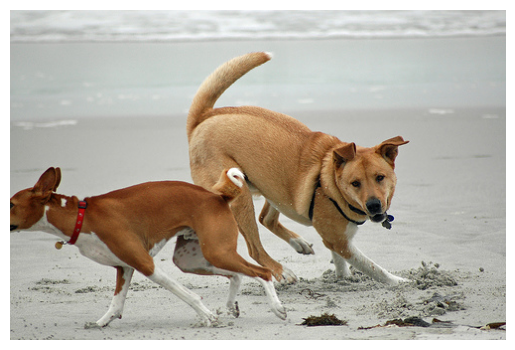

In [29]:
image = Image.open("/root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1/flickr8k/images/1024138940_f1fefbdce1.jpg").convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.show()

In [30]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1/flickr8k/captions.txt", sep=',')
df.loc[df['image']=='1024138940_f1fefbdce1.jpg']['caption']

,caption
100,Two different breeds of brown and white dogs p...
101,Two dogs are making a turn on a soft sand beach .
102,Two dogs playing in the sand at the beach .
103,Two dogs playing together on a beach .
104,Two large tan dogs play along a sandy beach .


In [33]:
model.eval()
test_img = transform(Image.open("/root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1/flickr8k/images/1024138940_f1fefbdce1.jpg").convert("RGB")).unsqueeze(0)
print("Example 1 OUTPUT: "+ " ".join(model.caption_image(test_img.to(device), dataset.vocab)))

Example 1 OUTPUT: <SOS> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


The model does not predict the caption properly (as consistent with epoch loss values). Can do better with more epoch runs, with higher processing power.